### Introduction

To showcase and further develop my knowledge of Generative AI techniques, particularly with Stable Diffusion, I have implemented the ideas from DiffEdit: Diffusion-based Semantic Image Editing with Mask Guidance (Zhu et al., 2022) in this notebook. This implementation leverages diffusion models for semantic image editing, allowing for targeted modifications of images based on user-defined masks and textual prompts.

While the notebook is functional and produces reasonable results, there remains room for improvement in both performance and image quality.

One example is that there are models that are designed specifically for taking a mask and adding the edit, which create better images, but I wanted to create the whole process of mask creation and processing myself.

This project is a step towards mastering GenAI techniques, demonstrating my practical knowledge of Stable Diffusion in the context of semantic image editing.

### Imports:

In [20]:
import logging
from pathlib import Path

from tqdm.auto import tqdm
from fastai.basics import show_image,show_images
import torch
import numpy as np
from torchvision import transforms
from huggingface_hub import notebook_login
from PIL import Image
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import cv2

logging.disable(logging.WARNING)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

### Pre-Trained Models:

These are the models that will be leveraged to produce these edits

In [5]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16, clean_up_tokenization_spaces=True)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

### Utility Functions:

Functions designed to help in image and prompt formatting

In [6]:
def word_to_embeddings(text):
    tokens = tokenizer(text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        return text_encoder(tokens.input_ids.to("cuda"))[0].half()
    
def image_to_latent(img_path):
    image = Image.open(img_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize the image to 512x512
        transforms.ToTensor()  # Convert the image to a PyTorch tensor
    ])

    image_tensor = transform(image).to("cuda")

    with torch.no_grad(): 
        noisy_tensor = vae.encode(image_tensor[None] * 2 - 1)

    latent = noisy_tensor.latent_dist.sample().to("cuda") * 0.18215

    return latent

def latents_to_image(latent):
    latent = latent.float()
    with torch.no_grad(): images = vae.decode(1 / 0.18215 * latent).sample
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images[0].detach().cpu().permute(1, 2, 0).numpy()
    images = (images * 255).round().astype("uint8")
    return Image.fromarray(images)

### Mask Making:

This is the central part of the project which involves creating a mask by adding the same noise to an image and finding the difference between the preds of two different prompts.

The parameters used have been determined from some experimentation, although some tuning might help improve mask accuracy a bit better, although, as mentioned in the paper, some extra padding in the mask is beneficial since it allows for more freedom for the edit which may be required for a reasonable result.

In [7]:
def pred_noise(img_latent, prompt, seed=torch.seed(), strength=0.5, guidance_scale=7.5, mask=None, device="cuda"):
    # Since this function is also used for the final edit, it needs to check if adding the mask is needed
    if mask is not None:
        if not isinstance(mask, torch.Tensor):
            mask = torch.tensor(mask)
            mask = mask.unsqueeze(0).unsqueeze(0).to(device).half()
        else:
            mask = mask.unsqueeze(0).unsqueeze(0).to(device).half()

    num_inference_steps = 50
    torch.manual_seed(seed)

    # Get word embeddings of the prompt and add a unconditioned embedding to increase variety
    prompt_embs = word_to_embeddings(prompt)
    uncond = word_to_embeddings('')
    embs = torch.concat([uncond, prompt_embs])

    # Set up the schedular to find out which time step it should start from according to the given strength
    scheduler.set_timesteps(num_inference_steps)
    offset = scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device=device)

    # Generate noise of the same shape as the latents
    noise = torch.randn_like(img_latent)
    # Use the scheduler to add noise to the latents based on the current timestep
    latent = scheduler.add_noise(img_latent, noise, timesteps=timesteps).to(device).half()

    # Get the timesteps to be used for removing noise
    t_start = max(num_inference_steps - init_timestep + offset, 0)
    timesteps = scheduler.timesteps[t_start:].to(device)

    for i, t in enumerate(timesteps):

        # If the mask is given, overwrites all masked pixels with the orignal image's noisy version at the current timestep
        if mask is not None:
            non_edit_features = scheduler.add_noise(img_latent, noise, timesteps=torch.tensor([t], device=device)).half()
            latent = latent * mask + non_edit_features * (1-mask)

        # Creates the input which is two latents: one with guidance and one without
        input = torch.cat([latent] * 2)
        input = scheduler.scale_model_input(input, t)

        # predict the noise residual
        with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=embs).sample

        # perform guidance calc
        pred_uncond, pred_text = pred.chunk(2)
        pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

        # compute the "previous" noisy sample
        latent = scheduler.step(pred, t, latent).prev_sample

    return latents_to_image(latent), pred

In [13]:
def calculate_diffs(latent, prompts, n=20, seed_value=torch.seed()):
    """Function which creates n predicitons for each prompt and finds the difference between them"""
    diffs = []
    
    # Gets seeds to feed to models
    torch.manual_seed(seed_value)
    seed_list = [torch.randint(0, 2**32, (1,)).item() for _ in range(n)]

    for sd in tqdm(seed_list):
        # Finds the pred noise for the orignal prompt and the prompt of the edit
        Rimg, Rnoise = pred_noise(latent, prompts[0], seed=sd, strength=0.5)

        Qimg, Qnoise = pred_noise(latent, prompts[1], seed=sd, strength=0.5)

        # Finds the Euclidian difference between the two
        diffs.append((Rnoise-Qnoise)[0].pow(2).sum(dim=0).pow(0.5)[None])

    diffs = torch.concat(diffs)
    return diffs

def normalization(diffs):
    # Finds the average of the differences
    avg_diff = diffs.mean(axis=0)
    normal_diff = (avg_diff-avg_diff.min())/(avg_diff.max()-avg_diff.min()) # rescale to interval [0,1]
    return normal_diff

def create_mask(diff, threshold=0.35):
    mask = np.array(diff.cpu()).astype(np.float32)
    # Adds blur to improve the cover of the mask on important areas
    mask = cv2.GaussianBlur(mask,(5,5),1)
    # Creates a mask by converting values below threshold to 0 and above to 1
    mask = (mask > threshold)
    return mask

def get_mask_from_diff(diffs):
    normal_diff = normalization(diffs)
    mask = create_mask(normal_diff)
    return mask

def get_blended_mask(image_path,mask): 
    # Gets of photo of a mask overlayed on original image
    image = Image.open(image_path)
    image = image.resize((512,512))
    mask = (mask*255.).astype(np.uint8)
    mask = Image.fromarray(mask)
    mask = mask.resize((512,512))
    mask_rgb = mask.convert('RGB')
    return Image.blend(image,mask_rgb,0.40)

def calculate_mask(img_path, prompts, seed=torch.seed()):
    latent = image_to_latent(img_path)
    diffs = calculate_diffs(latent, prompts, seed_value=seed)
    mask = get_mask_from_diff(diffs)
    return mask

Examples of images with the mask overlay are shown below

  0%|          | 0/10 [00:00<?, ?it/s]

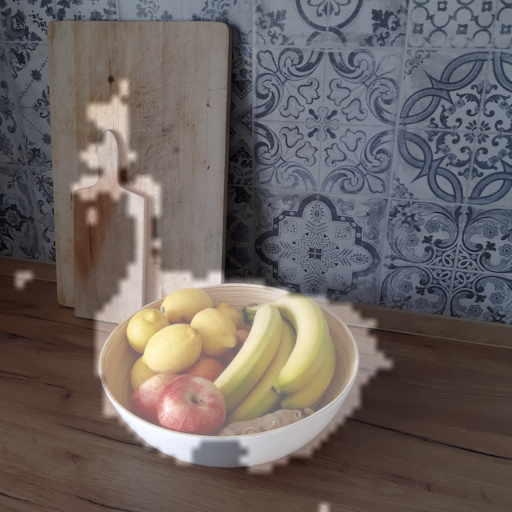

In [21]:
seed = 42

img_path = 'fruitbowl_scaled.jpg'

prompts = ['Bowl of Fruit','Bowl of Grapes']

mask = calculate_mask(img_path,prompts, seed=42)

get_blended_mask(img_path, mask)

  0%|          | 0/10 [00:00<?, ?it/s]

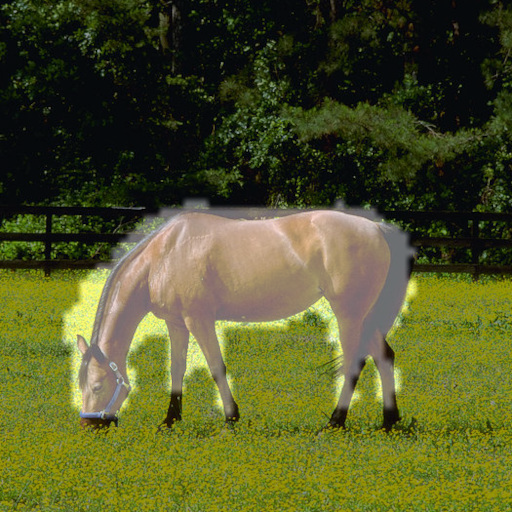

In [22]:
seed = 42

img_path = 'other_horse.jpg'

prompts = ['horse','zebra']

torch.cuda.empty_cache()
mask = calculate_mask(img_path,prompts, seed=42)
get_blended_mask(img_path, mask)

### Step 2: Create Edits

In [9]:
def create_edit(image_path, prompts, mask=None, seed=torch.seed()):
    latent = image_to_latent(image_path)

    if mask is None:
        mask = calculate_mask(image_path, prompts, seed=seed)

    edited_image, pred = pred_noise(latent, prompts[1], seed=seed, strength=0.8, mask=mask)
    return edited_image

  0%|          | 0/20 [00:00<?, ?it/s]

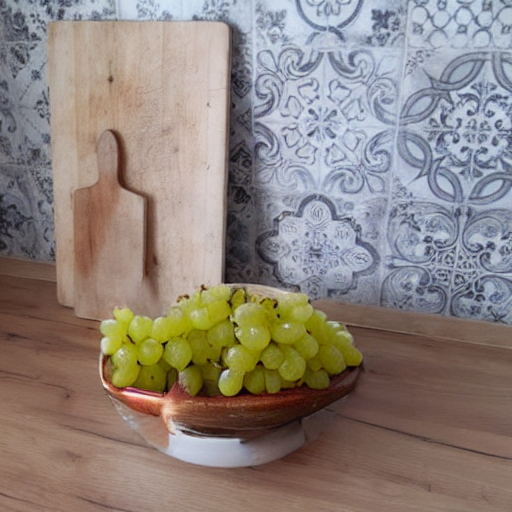

In [16]:
seed = 42

img_path = 'fruitbowl_scaled.jpg'

prompts = ['Bowl of Fruit','Bowl of Grapes']

create_edit(img_path, prompts, seed=seed)

Not a perfect edit, but there are now grapes and the background is mostly undisturbed.

  0%|          | 0/10 [00:00<?, ?it/s]

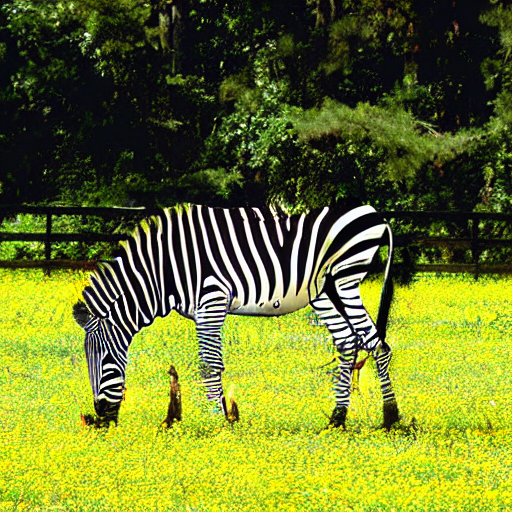

In [23]:
seed = 42

img_path = 'other_horse.jpg'

prompts = ['horse','zebra']

create_edit(img_path, prompts, seed=seed)

Not a perfect edit, but the background is undisturbed and it looks like a zebra

### Putting It All Together

Here are some examples of the full process and result to better show the idea at work

In [16]:
# Show the original image, the original image with mask and the resulting inpainted image
def demo_diffedit(img_path,prompts, seed=torch.seed(), device="cuda"):
    out = []
    out.append(Image.open(img_path))
    mask = calculate_mask(img_path,prompts, seed=seed)
    out.append(get_blended_mask(img_path,mask))
    out.append(create_edit(img_path, prompts, mask=mask, seed=seed))
    show_images(out)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

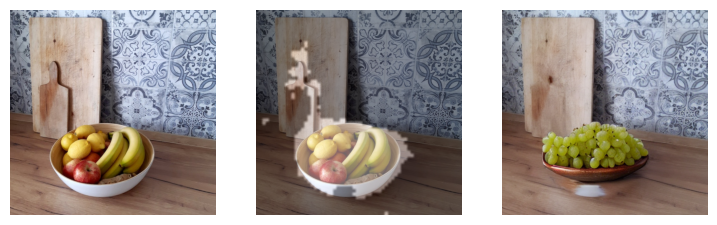

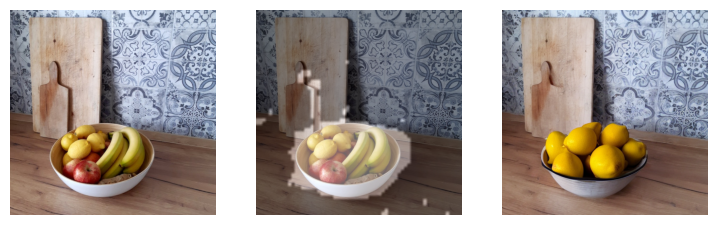

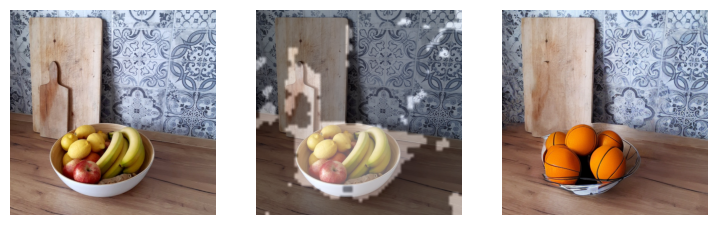

In [19]:
seed = 42

img_path = 'fruitbowl_scaled.jpg'

prompts1 = ['Bowl of Fruit','Bowl of Grapes']
prompts2 = ['Bowl of Fruit','Bowl of Lemons']
prompts3 = ['Bowl of Fruit','Bowl of Basket Balls']

demo_diffedit(img_path, prompts1, seed=seed)
demo_diffedit(img_path, prompts2, seed=seed)
demo_diffedit(img_path, prompts3, seed=seed)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

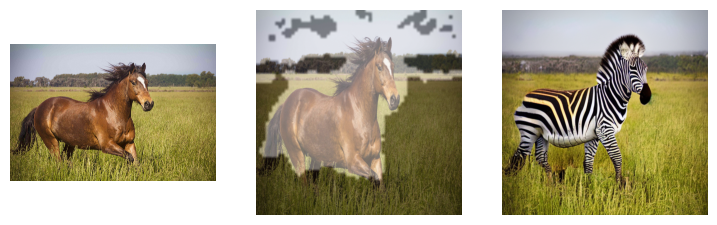

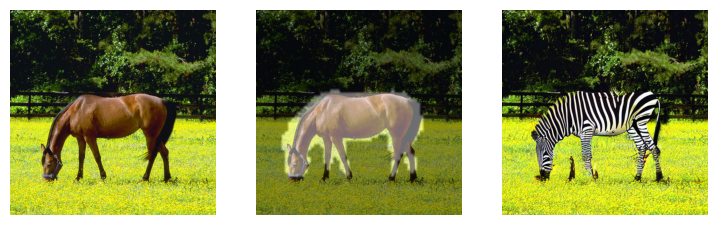

In [18]:
seed = 42

img_path = 'horse.jpg'
other_img_path = 'other_horse.jpg'

prompts = ['Horse','Zebra']

demo_diffedit(img_path, prompts, seed=seed)
demo_diffedit(other_img_path, prompts, seed=seed)